# **ch.08 이미지를 위한 인공 신경망**  
## 08-2 합성곱 신경망을 사용한 이미지 분류  
### 풀어야 할 문제:  
> ### keras를 이용하여 Fashion MNIST classification을 수행하는 CNN model을 만들어라

<br/>

### *패션 MNIST 데이터 불러오기*  
data 준비하기  
+ keras API로 Fashion MNIST data 불러오기
+ convolution layer의 3 dimension input을 위해 channel dimension 추가
+ data scale normalization
+ data set split




















In [16]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

### *합성곱 신경망 만들기*  
convolution neural network의 전형적인 구조는 convolution layer로 image에서 특징을 감지한 후 dense layer로 class에 따른 probability를 계산  


CNN 만들기
+ `Sequential` object 만들기
+ convolution layer 추가  
  + 32개 filter
  + kernel size = (3, 3)
  + ReLU activation function
  + same padding
  + model의 첫 layer이므로 input shape 지정

In [17]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

+ max pooling layer 추가
  + pooling size = (2, 2)

In [18]:
model.add(keras.layers.MaxPooling2D(2))

convolution layer에서 same padding을 사용했고, pooling layer에서 (2, 2)의 pooling을 적용했으므로 pooling layer를 지난 feature map의 2 dimension shape은 same padding을 적용한 input data의 절반 크기  
convolution layer에서 32개 filter를 사용했으므로 feature map의 depth dimension은 32


+ convolution layer 추가
  + 64개 filter
  + kernel size = (3, 3)
  + ReLU activation function
  + same padding
+ max pooling layer 추가
  + pooling size = (2, 2)










In [19]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))

model.add(keras.layers.MaxPooling2D(2))

+ flatten layer 추가  
3 dimension인 feature map을 flatten하기  
$\because$ 10개 class에 대한 probability를 계산하기 위해 dense layer에 feature map을 입력해야 하기에
+ dense hidden layer 추가
  + 100 neuron
  + ReLU activation function
+ dropout layer 추가
+ dense output layer 추가
  + 10 neuron
  + softmax activation function

In [20]:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(10, activation='softmax'))

keras API를 사용하면 kernel, padding, pooling 등을 조정하여 손쉽게 다양한 구성을 실험해 볼 수 있음

<br/>

model summary 확인

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

convolution layer와 pooling layer의 효과가 잘 나타남  


첫 번째 convolution layer를 통과하며 feature map의 depth didemsion은 32가 되고, 두 번째 convolution layer를 통과하며 64가 됨  
한편, feature map의 2 dimension size는 첫 번째 pooling layer를 지나며 절반이 되고, 두 번째 pooling layer를 지나며 또 다시 절반이 됨  
&rarr; 최종 feature map의 size = (7, 7, 64)

<br/>

keras는 `summary()` method 외에도 layer의 구성을 그림으로 표현해주는 `plot_model()` function을 `keras.utils` package 아래 제공


`plot_model()` function으로 model 확인

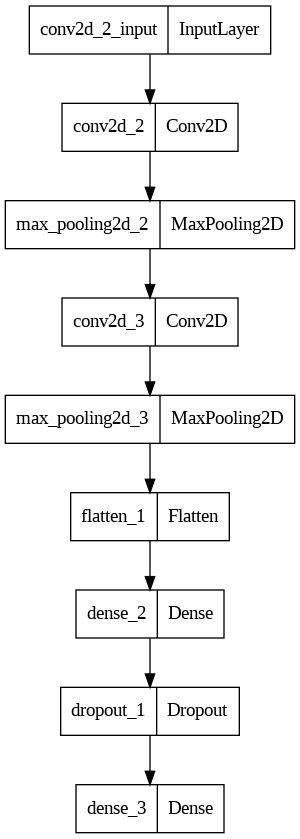

In [22]:
keras.utils.plot_model(model)

box안의 내용 중 colon 왼쪽에는 layer의 이름이, 오른쪽에는 class가 나타남


가장 먼저 나오는 InputLayer class는 keras가 자동으로 추가해 주는 것으로, input layer의 역할을 함  
이 input layer는 model의 첫 번째 layer인 `Conv2D` layer의 `input_shape` parameter를 사용함

<br/>

`plot_model()` function의 parameter
+ `show_shapes` parameter를 `True`로 지정하면 그림에 input과 output의 size를 표시해 줌
+ `to_file` parameter에 file 이름을 지정하면 그림을 저장해 줌
+ `dpi` parameter로 해상도 지정

<br/>

parameter를 사용해 다시 image 그리기

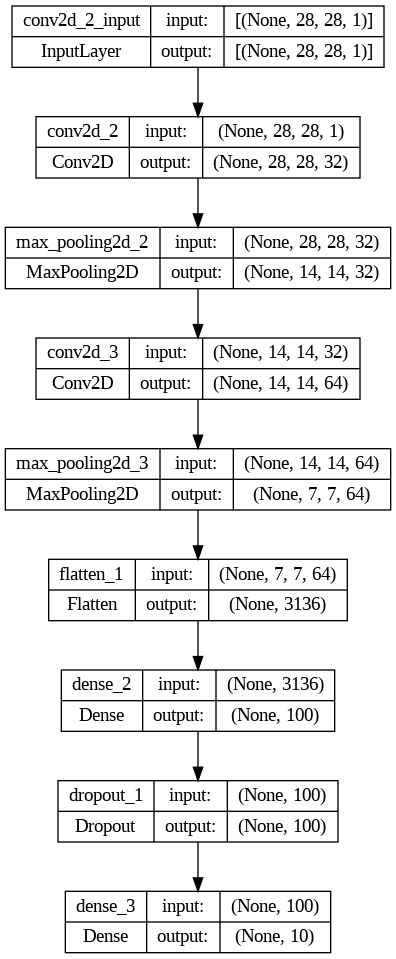

In [23]:
keras.utils.plot_model(model, show_shapes=True)

### *모델 컴파일과 훈련*  
compile model
+ Adam optimizer
+ sparse categorical crossentropy loss function
+ accuracy

train model
+ ModelCheckpoint, EarlyStopiing callbacks

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 8s 4ms/step - loss: 0.5325 - accuracy: 0.8090 - val_loss: 0.3301 - val_accuracy: 0.8780
Epoch 2/20
  31/1500 [..............................] - ETA: 4s - loss: 0.3711 - accuracy: 0.8659

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3513 - accuracy: 0.8738 - val_loss: 0.2845 - val_accuracy: 0.8943
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3006 - accuracy: 0.8927 - val_loss: 0.2556 - val_accuracy: 0.9053
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2701 - accuracy: 0.9031 - val_loss: 0.2449 - val_accuracy: 0.9070
Epoch 5/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2466 - accuracy: 0.9101 - val_loss: 0.2383 - val_accuracy: 0.9143
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2257 - accuracy: 0.9185 - val_loss: 0.2201 - val_accuracy: 0.9189
Epoch 7/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2080 - accuracy: 0.9231 - val_loss: 0.2255 - val_accuracy: 0.9175
Epoch 8/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1900 - accuracy: 0.9295 - val_loss: 0.2242 - val_accuracy: 0.9197


loss curve를 그려 early stopping이 잘 이루어졌는지 확인

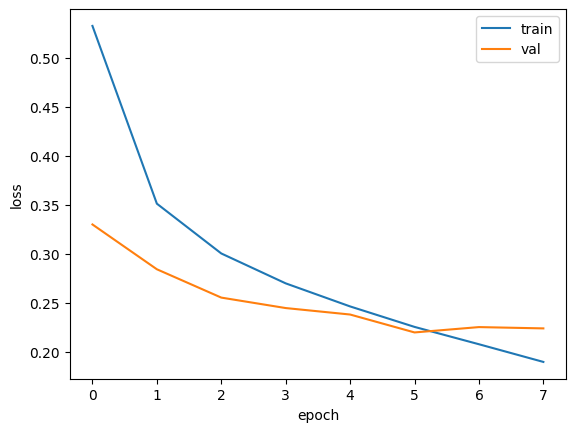

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

validation loss가 감소하다가 정체되기 시작하고 train loss는 꾸준히 감소  
여섯 번째 epoch를 최적이라 판단할 수 있음

<br/>

`EarlyStopping` callback class의 `restore_best_weights` parameter를 `True`로 지정하였으므로 현재 model은 최적의 parameter로 복원되어 있음  
&rarr; 최적의 model을 사용하기 위해 `ModelCheckpoint` callback으로 저장한 weights를 불러올 필요가 없음


validation set에 대한 performance 확인

In [26]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.2201 - accuracy: 0.9189


[0.22006258368492126, 0.918916642665863]

이 결과는 앞선 training 과정 중 여섯 번째 epoch에서의 결과와 동일

<br/>

`predict()` method로 trained model의 새로운 data에 대한 prediction 만들기  
본 practice에서는 편의상 validation set의 첫 번째 sample을 새로운 data라고 가정
+ image(sample) 확인을 위해 matplotlib로 sample 그려보기  
matplotlib에서 gray scale image에는 depth channel은 없음  
&rarr; (28, 28, 1)인 sample size를 (28, 28)로 바꾸어 그려야 함










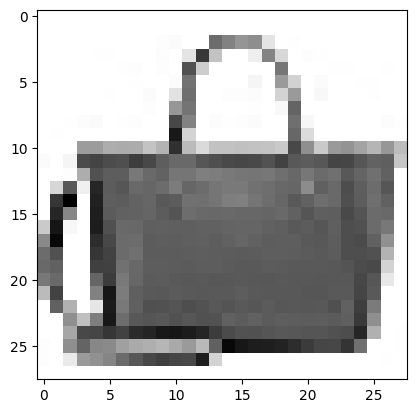

In [27]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

핸드백 image


+ `predict()` method로 model의 prediction 확인  
`predict()` method는 input의 첫 번째 dimension을 batch dimension으로 기대함  
$\therefore$ sample을 전달할 때 (1, 28, 28, 1)로 전달해야 함  
&rarr; array indexing은 indexing과 다르게 선택된 element가 하나이더라도 전체 dimension이 유지되어 (1, 28, 28, 1)로 전달할 수 있음

In [28]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 181ms/step
[[1.51931436e-14 5.40899358e-18 7.54965594e-18 3.11619250e-15
  1.48113333e-14 1.44079457e-14 3.23690385e-16 5.44404311e-13
  1.00000000e+00 1.21707886e-14]]


아홉 번째 class의 value가 1이고, 나머지 class의 value는 0에 가까움  
&rarr; predict 결과를 bar graph로 그려 visualization

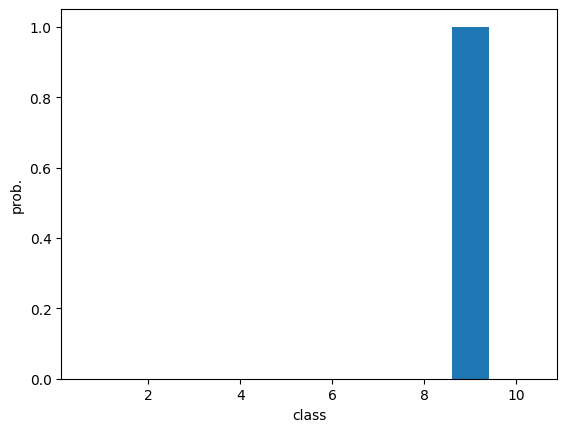

In [29]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

Fashion MNIST의 label을 list로 저장

In [30]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

`preds` array에서 가장 큰 index를 찾아 `classes` list의 index로 사용하여 prediction 결과 확인

In [31]:
import numpy as np

print(classes[np.argmax(preds)])

가방


test set에 대한 performance 확인
+ data 준비
  + train set과 validation set에서 했던 것처럼 test set의 scale normalization

In [32]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

+ performace 확인

In [33]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 4ms/step - loss: 0.2392 - accuracy: 0.9121


[0.23922409117221832, 0.9121000170707703]

실전에 투입했을 때 91%의 정확도를 보일 것으로 기대할 수 있음